In [1]:
!pip install rapidfuzz
!pip install jmespath
!pip install transformers[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.4/427.4 kB 33.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of onnxconverter-common to determine which version is compatible with other requirements

In [3]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import pandas as pd
import re
from datasets import load_dataset
from rapidfuzz import process, fuzz
from tqdm import tqdm  # 用於顯示進度條

# 加載 Djinni Recruitment Dataset (English Job Descriptions part)
data = load_dataset("lang-uk/recruitment-dataset-job-descriptions-english")['train']
df = data.to_pandas()

# 改進的清理職位名稱函數
def clean_position(position):
    # 移除開頭的數字和特殊字符
    position = re.sub(r"^\d+[^\w]*", "", position)  # 處理開頭數字或非單詞字符
    position = re.sub(r"^\d+[\s/]*", "", position)  # 開頭數字後接空格或斜線
    # 移除括號中的內容
    position = re.sub(r"\(.*?\)", "", position)
    # 移除多餘的特殊字符
    position = re.sub(r"[^\w\s/]", "", position)
    # 壓縮多個空格為單個空格
    position = re.sub(r"\s+", " ", position).strip()
    return position

# 應用清理函數
tqdm.pandas(desc="Cleaning Positions")
df['Cleaned Position'] = df['Position'].progress_apply(clean_position)

# 進行標準化處理
unique_positions = df['Cleaned Position'].unique()
standardized_names = []
for position in tqdm(unique_positions, desc="Generating Standardized Names"):
    if any(fuzz.ratio(position, std) > 80 for std in standardized_names):
        continue
    standardized_names.append(position)

mapping = {}
for position in tqdm(unique_positions, desc="Creating Mapping"):
    match, score, _ = process.extractOne(position, standardized_names, scorer=fuzz.ratio)
    if score > 90:
        mapping[position] = match
    else:
        mapping[position] = position

tqdm.pandas(desc="Standardizing Positions")
df['Standardized Position'] = df['Cleaned Position'].progress_apply(lambda x: mapping.get(x, x))

# 查看結果
print(df[['Cleaned Position', 'Standardized Position']].head(20))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/146M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/141897 [00:00<?, ? examples/s]

Standardizing Positions: 100%|██████████| 141897/141897 [00:00<00:00, 1028263.92it/s]

                            Cleaned Position  \
0   Blockchain Nodes / Masternodes to set up   
1                             NET Developers   
2                                 X Engineer   
3                       Amazon Brand Manager   
4                       Amazon Brand Manager   
5                              PHP Developer   
6                              Sales Manager   
7       Middle / Senior marketing specialist   
8               Business Development Manager   
9                  Middle DataBase developer   
10              Lead/Senior Backend Engineer   
11                     Senior Java Developer   
12         Trainee/Junior Database developer   
13                   Middle Python Developer   
14            Junior Ruby on Rails Developer   
15                           DevOps Engineer   
16             Senior Java Software Engineer   
17       Middle Java Developer Welcome Bonus   
18                           C/Baf developer   
19                                 C bas

<ipython-input-5-6bf6e0912f34>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=position_counts.values, y=position_counts.index, palette="viridis")


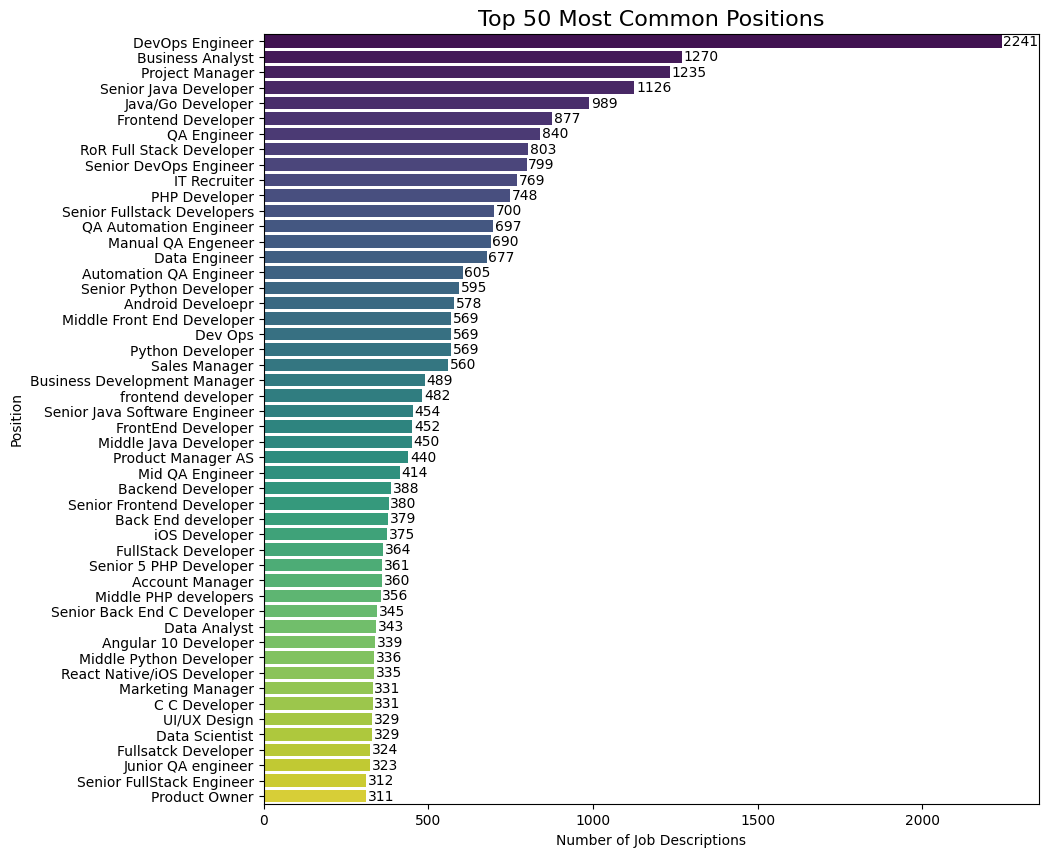

總職位數量: 141897
清理後的唯一職位數量: 49376
標準化後的唯一職位數量: 43861


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 計算職位名稱的分佈
position_counts = df['Standardized Position'].value_counts().head(50)

# 繪製條形圖
plt.figure(figsize=(10, 10))
sns.barplot(x=position_counts.values, y=position_counts.index, palette="viridis")
plt.title("Top 50 Most Common Positions", fontsize=16)
plt.xlabel("Number of Job Descriptions")
plt.ylabel("Position")
# 添加數值標籤
for index, value in enumerate(position_counts.values):
    plt.text(value + 5, index, str(value), va='center')  # 調整位置
plt.show()


# 總職位數量
total_positions = df['Position'].count()
print(f"總職位數量: {total_positions}")
# 唯一職位數量（清理後）
unique_cleaned_positions = df['Cleaned Position'].nunique()
print(f"清理後的唯一職位數量: {unique_cleaned_positions}")
# 唯一職位數量（標準化後）
unique_standardized_positions = df['Standardized Position'].nunique()
print(f"標準化後的唯一職位數量: {unique_standardized_positions}")

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# 清理職位描述
def clean_description(text):
    text = re.sub(r'\d+', '', text)  # 移除數字
    text = re.sub(r'[^\w\s]', '', text)  # 移除標點符號
    text = re.sub(r'\s+', ' ', text).strip()  # 移除多餘空格
    return text

tqdm.pandas(desc="Cleaning Descriptions")
df['Cleaned Description'] = df['Long Description'].progress_apply(clean_description)
df['Cleaned Description']

Cleaning Descriptions: 100%|██████████| 141897/141897 [00:25<00:00, 5506.83it/s]


,Cleaned Description
0,Requirements Were looking for a long term coll...
1,Greetings My name is Maria I am in urgent need...
2,Product The product is a live video chat and c...
3,Currently TCM expanding its activities to Ukra...
4,Hello We MIMIRBB are an outstaff company and n...
...,...
141892,We are looking for a highly motivated and resu...
141893,We are looking for an experienced targetologis...
141894,Responsibilities Analyze and estimate implemen...
141895,Duties and Responsibilities HelpdDeliver a hig...


In [8]:
!pip install pytextrank

In [14]:
# 在 Google Colab 中執行以下命令安裝必要的依賴
!pip install -U spacy[cuda] pytextrank tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 122.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cupy
  Running setup.py clean for cupy
Failed to build cupy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cupy)


In [18]:
!nvcc --version
!sudo apt-get install build-essential
!pip install numpy fastrlock
!pip install cupy --no-binary cupy


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cupy
  Running setup.py clean for cupy
Failed to build cupy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cupy)


In [22]:
import spacy
import pytextrank
import pandas as pd
from tqdm import tqdm

# 加載 SpaCy 並添加 PyTextRank
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")

# 定義提取關鍵短語的函數，並將處理過程加入 tqdm
def extract_keyphrases_with_progress(texts):
    keyphrases = []
    for text in tqdm(texts, desc="Processing Text with SpaCy"):
        doc = nlp(text)
        keyphrases.append([phrase.text for phrase in doc._.phrases[:10]])  # 提取前10個關鍵短語
    return keyphrases

# 假設 df 已經包含 'Cleaned Description' 列
# 使用 tqdm 查看進度
df['Keyphrases'] = extract_keyphrases_with_progress(df['Cleaned Description'])

# 查看結果
print(df[['Cleaned Description', 'Keyphrases']].head())

# 保存部分結果到文件
df[['Cleaned Description', 'Keyphrases']].to_csv("keyphrases_sample.csv", index=False)
print("關鍵短語提取結果已保存到 keyphrases_sample.csv")


Processing Text with SpaCy: 100%|██████████| 141897/141897 [1:50:54<00:00, 21.33it/s]


                                 Cleaned Description  \
0  Requirements Were looking for a long term coll...   
1  Greetings My name is Maria I am in urgent need...   
2  Product The product is a live video chat and c...   
3  Currently TCM expanding its activities to Ukra...   
4  Hello We MIMIRBB are an outstaff company and n...   

                                          Keyphrases  
0  [long term collaboration, Kyber Network Nebula...  
1  [Net Framework Net Core, NET Net Core ASPNET h...  
2  [companys products, couple other companies, Lo...  
3  [Amazon product management marketing, product ...  
4  [Amazon product management marketing, product ...  
關鍵短語提取結果已保存到 keyphrases_sample.csv


In [25]:
from sklearn.model_selection import train_test_split
# 劃分訓練集和測試集
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
print(df.head())

                                            Position  \
0      10 + Blockchain Nodes / Masternodes to set up   
1       10 .NET Developers (Middle and Senior level)   
2  10X Engineer (co-founder, #4 employee, USD 11-...   
3                          16 - Amazon Brand Manager   
4                          16 - Amazon Brand Manager   

                                    Long Description    Company Name  \
0  *Requirements*\r\n\r\nWe're looking for a long...    MyCointainer   
1  Greetings! My name is Maria, I am in urgent ne...  TechScout.tech   
2  **Product**\r\nThe product is a live video cha...        Innoteka   
3  Currently, TCM expanding its activities to Ukr...       FirstFive   
4  Hello,\r\nWe, MIMIRB2B, are an outstaff compan...        MimirB2B   

  Exp Years Primary Keyword English Level                  Published  \
0        2y        Sysadmin  intermediate  2020-10-01T00:00:00+03:00   
1        2y            .NET  intermediate  2022-03-01T00:00:00+02:00   
2        5y   

In [ ]:
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm import tqdm
from google.colab import drive
import pandas as pd

# Step 1: Combine Cleaned Description and Keyphrases
# Combine Cleaned Description and Keyphrases into Model Input
df['Model Input'] = df['Cleaned Description'] + " " + df['Keyphrases'].apply(lambda x: " ".join(x))

# Encode Standardized Position into Labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Standardized Position'])

# Step 2: Convert DataFrame to Dataset
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["Model Input"], truncation=True, padding=True, max_length=512)

dataset = Dataset.from_pandas(df[['Model Input', 'Label']])
dataset = dataset.map(preprocess_function, batched=True, desc="Tokenizing Data")
dataset = dataset.rename_column("Label", "labels")

# Split into Train and Test datasets
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Step 3: Mount Google Drive
drive.mount('/content/drive')

# Step 4: Load Pre-trained Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(df['Label'].unique())
)

# Step 5: Training Arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/transformer_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/logs",
    logging_steps=10,
    save_steps=100,
    save_total_limit=2
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Step 6: Fine-tune the Model
tqdm.write("Starting Fine-tuning...")
trainer.train()
tqdm.write("Fine-tuning Complete!")

# Save Model
model.save_pretrained("/content/drive/MyDrive/hr_model")
tokenizer.save_pretrained("/content/drive/MyDrive/hr_model")


Tokenizing Data:   0%|          | 0/141897 [00:00<?, ? examples/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-db1d1620f7f5>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Fine-tuning...


wandb: WARNING Serializing object of type dict that is 2621536 bytes
wandb: WARNING Serializing object of type dict that is 2621536 bytes


Epoch,Training Loss,Validation Loss


In [28]:
from datasets import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm

# 加載分詞器
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 分詞處理函數
def preprocess_function(examples):
    return tokenizer(examples["Model Input"], truncation=True, padding=True, max_length=512)

# 轉換為 Dataset 並顯示進度條
tqdm.pandas(desc="Building Dataset")
dataset = Dataset.from_pandas(df[['Model Input', 'Label']])

dataset = dataset.map(preprocess_function, batched=True, desc="Tokenizing Data")
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing Data:   0%|          | 0/141897 [00:00<?, ? examples/s]

In [31]:
print(train_dataset[0])  # 應包含 `input_ids`, `attention_mask`, `labels`


{'Model Input': 'Platform for a construction business that makes helps construction managers with equipment assets reports documents and processes management The software also includes an application for construction workers that allows to track their work and communicate with workers in chat directly Technology stack of project Frontend Angular HTMLCSS Responsive Layouts JavaScript Backend Microservices Architecture Java Spring Boot MongoDB MariaDB Docker CQRS Axon Framework Mandatory Requirements years of commercial software development experience with Java A comprehensive foundation with objectoriented and functional programming languages such as Java Spring JS Angular Strong development experience with Java Spring Boot Event Sourcing CQRS MongoDB MariaDB Docker Excellent communication skills and upperIntermediate English Main Responsibilities Development of new features of existing webbased platform Implementing best practices and technical solutions Taking ownership of business re

In [30]:
from google.colab import drive
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm import tqdm

# 掛載 Google Drive
drive.mount('/content/drive')

# 加載預訓練模型
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(df['Label'].unique())  # 確認類別數
)

# 訓練參數
training_args = TrainingArguments(
    output_dir="./transformer_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=100,
)

# 初始化 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# 開始訓練
tqdm.write("Starting Fine-tuning...")
trainer.train()
tqdm.write("Fine-tuning Complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-30-df6a0703236d>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Fine-tuning...


wandb: WARNING Serializing object of type dict that is 2621536 bytes
wandb: WARNING Serializing object of type dict that is 2621536 bytes


ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,token_type_ids,attention_mask.